# EDA - NoMES


In [44]:
import pandas as pd

changes = pd.read_csv("./data_2020.csv",  sep=';')
changes.head()

,id,bikesAvailable,spacesAvailable,allowDropoff,isFloatingBike,state,realTimeData,time,week,yday,day,month,hour,minute,yhour,year
0,649,3,10,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
1,529,36,8,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
2,651,14,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
3,531,2,22,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
4,532,5,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020


In [3]:
# check for missing values (month, days per month)
# lists months and days per month

# expected values = something


def check_missing_values():

    months = changes['month'].unique()

    for m in months:
        print(m)
        month = changes[changes['month'] == m]
        
        print(month['day'].unique())
        
        # compare to expected values
    # return difference


maxspaces = max(changes["bikesAvailable"])

print(changes[changes["bikesAvailable"] == maxspaces])

check_missing_values()

           id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
30235312  124             171                1             1               0   

               state  realTimeData                 time  week  yday  day  \
30235312  Station on             1  2020/08/01 22:25:02    31   215    2   

          month  hour       minute  yhour  year  
30235312      8     1  0,416666660   3169  2020  
8
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31  1  2]
9
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
10
[ 1  2  3  4  5  6  7  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31]
11
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
3
[23 24 25 26 27 28 29 30 31]
4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
5
[ 4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31]
6
[ 1  

In [45]:
# separate stations in their own dataframes

telling_ids = changes['id'].unique()
stations = {}

for i in telling_ids:
    station = changes[changes['id'] == i]
    stations[i] = station

print(len(stations))
print(stations[11]
)

452
          id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
132       11              37                6             1               0   
582       11              37                6             1               0   
1032      11              38                6             1               0   
1482      11              38                6             1               0   
1932      11              38                6             1               0   
...       ..             ...              ...           ...             ...   
30369435  11              37                6             1               0   
30369885  11              37                6             1               0   
30370335  11              37                6             1               0   
30370785  11              37                6             1               0   
30371235  11              37                6             1               0   

               state  realTimeData             

In [7]:
# map station names to ids
# clean station names

def clean_names(names):
    # strip and removal of duplicates
    return set([name.strip() for name in names])


station_data = pd.read_csv("./tellingit_2017-2021.csv", sep=';')
station_names = station_data[station_data['year'] == 2020]['name'].unique()
station_names = clean_names(station_names)
station_ids = station_data[station_data['year'] == 2020]['id'].unique()

names_ids = {}

for ids in station_ids:
    name = station_data[station_data['id'] == ids].iloc[0]['name']
    names_ids[ids] = name


print(names_ids[11])

Unioninkatu


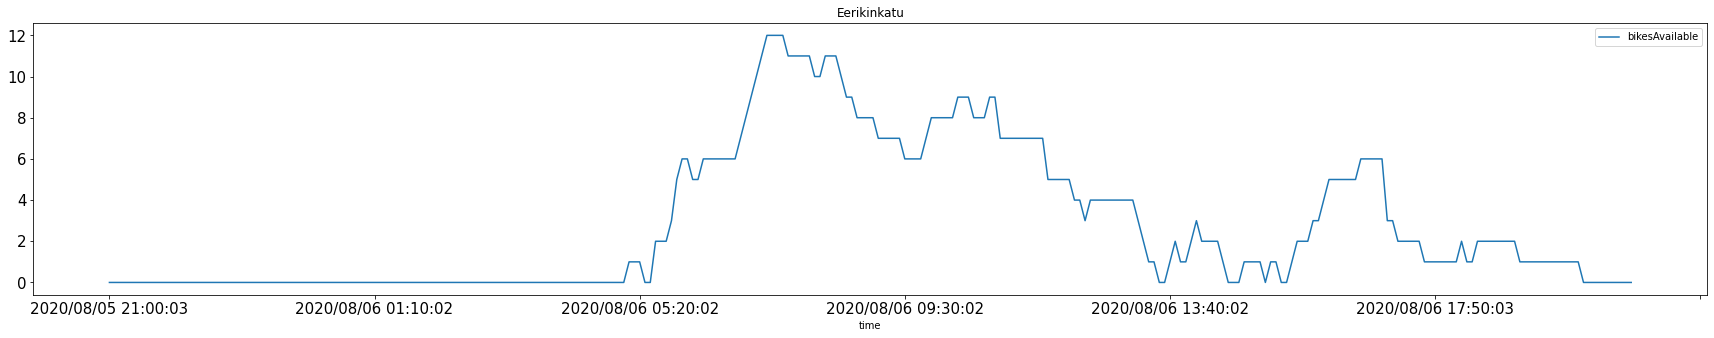

In [8]:
# plot changes per station over time X

import matplotlib.pyplot as plt

def filter_rows(yday: int, station_id: int, min_hour: int, max_hour: int) -> pd.DataFrame():
    yday = yday
    i = station_id
    station = stations[i]

    station = station[station['yday'] == yday]

    if min_hour is not None and max_hour is not None:
        station = station[(station['yhour'] >= min_hour) & (station['yhour'] <= max_hour)]

    return station


def plot_bike_changes(station_id, station):
    title = names_ids[station_id]
    station.plot(x='time', y='bikesAvailable', figsize=(30,5), fontsize=15, title=title)
    plt.savefig(f"img/{title}")

i = 27

station = filter_rows(219, i, None, None)
plot_bike_changes(i, station)


In [24]:
# Primary target: count how many times per day bikes drop to day's minimum

def count_drops(station):
    minbikes = min(station['bikesAvailable'])
    counts = 0
    was_min = False

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # drop starts
        if not was_min and bikes == minbikes:
            counts += 1
            was_min = True

        # drop ends
        elif was_min and bikes != minbikes:
            was_min = False

    return counts, minbikes

i = 113
station = filter_rows(219, i, None, None)
print(count_drops(station))
# plot_bike_changes(i, station)

(24, 2)


In [25]:
# Secondary target: Count the number of changes
# there is a change if the number of bikes is different than for the previous 5min (doesn't take into account the number of bikes changed)

def count_changes(station):
    counts = 0
    previous = -1

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # print(previous, bikes)
        if bikes != previous:
            # found change 
            counts += 1
            previous = bikes

        # print(counts)
    return counts

i = 11
station = filter_rows(218, i, None, None)
print("changes", count_changes(station))
# plot_bike_changes(i, station)

changes 124


In [67]:
changes = changes.assign(wday=changes['yday'] % 7 + 1)


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np

changes

,id,bikesAvailable,spacesAvailable,allowDropoff,isFloatingBike,state,realTimeData,time,week,yday,day,month,hour,minute,yhour,year,wday
132,11,37,6,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020,7
582,11,37,6,1,0,Station on,1,2020/08/02 23:45:03,32,216,3,8,2,"0,750000000",3194,2020,7
1032,11,38,6,1,0,Station on,1,2020/08/02 23:50:02,32,216,3,8,2,"0,833333300",3194,2020,7
1482,11,38,6,1,0,Station on,1,2020/08/02 23:55:02,32,216,3,8,2,"0,916666700",3194,2020,7
1932,11,38,6,1,0,Station on,1,2020/08/03 00:00:03,32,216,3,8,3,"0,000000000",3195,2020,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30369435,11,37,6,1,0,Station on,1,2020/08/02 23:15:02,32,216,3,8,2,"0,250000000",3194,2020,7
30369885,11,37,6,1,0,Station on,1,2020/08/02 23:20:02,32,216,3,8,2,"0,333333340",3194,2020,7
30370335,11,37,6,1,0,Station on,1,2020/08/02 23:25:02,32,216,3,8,2,"0,416666660",3194,2020,7
30370785,11,37,6,1,0,Station on,1,2020/08/02 23:30:02,32,216,3,8,2,"0,500000000",3194,2020,7


In [69]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["wday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

In [72]:
# predict number of bikes
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, TimeSeriesSplit, cross_val_score

station_i = 113
changes = stations[station_i]
changes = changes.assign(wday=changes['yday'] % 7 + 1)
X = changes.drop(["bikesAvailable", "spacesAvailable", "state", "time", "minute", "allowDropoff", "state", "isFloatingBike", "realTimeData"], axis=1)
y = changes["bikesAvailable"]

# print(len(X), len(y))

# test_size requires scikit-learn>=0.24.0
tscv = TimeSeriesSplit(n_splits = 5, gap=576, test_size=2880, max_train_size=10000)
# print(tscv)


# scores = cross_val_score(rl, X, y, cv=tscv)
# print(scores)

predictions = []

cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    HistGradientBoostingRegressor(loss='poisson'),
)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(len(X_train), len(X_test), len(y_train), len(y_test))

    model = cyclic_spline_linear_pipeline
    rl = model.fit(X_train, y_train)
    score = rl.score(X_test, y_test)
    predicted = rl.predict(X_test)

    predictions.append(predicted)

model = HistGradientBoostingRegressor(loss='poisson')
scores = cross_val_score(model, X, y, cv=tscv)
print(scores)
predictions_indexed = [pd.Series(prediction, index = y_test.index) for prediction in predictions]

10000 2880 10000 2880
10000 2880 10000 2880
10000 2880 10000 2880
10000 2880 10000 2880
10000 2880 10000 2880
[-0.82714448  0.03690591  0.13682927 -0.16176809 -0.1735088 ]


In [73]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(model, X, y, cv=tscv)

Mean Absolute Error:     3.427 +/- 0.473
Root Mean Squared Error: 5.754 +/- 0.967


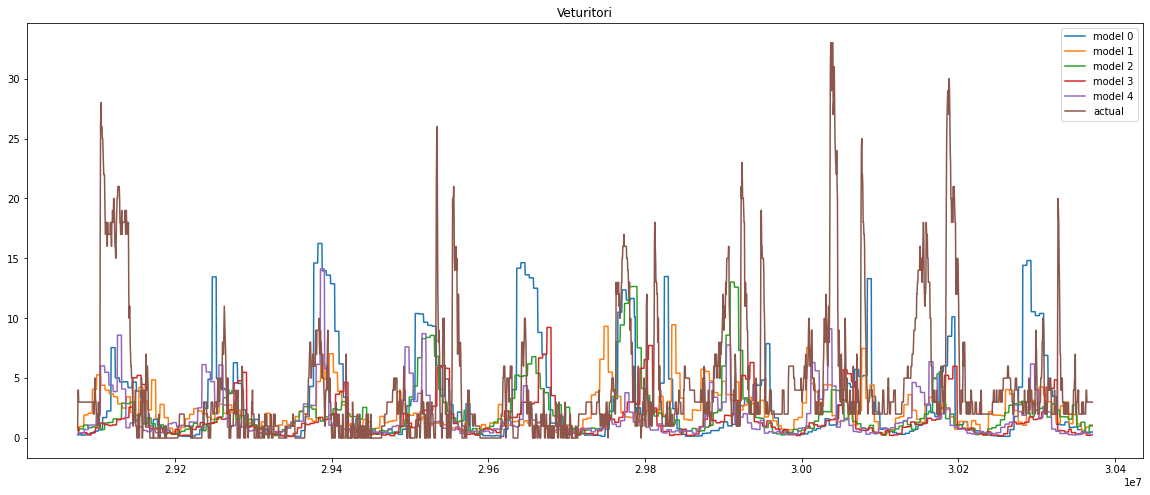

In [74]:
# plot predictions
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)

for i, prediction in enumerate(predictions_indexed):
    plt.plot(prediction, label=f"model {i}")

plt.plot(y_test, label="actual")
plt.legend()
plt.title(names_ids[station_i])
plt.show()